#### This notebook we will work in DecisionTreeClassifier


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.model_selection import GridSearchCV

%matplotlib inline
SEED = 42

In [2]:
# Read processe file
df = pd.read_csv('../data/processed_balanced_transaction.csv')
df.shape

(21784, 34)

#### Lets separate Level and features, Scaled features


In [3]:
X, y = df.drop(['isFraud'],axis=1), df['isFraud']

#### Split data into train test 
 We are spliting data into train and test with ratio 30%. Means 30% test and 70% train data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

#### Create a DessionTree classifier and fit all features

In [5]:
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=SEED)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

In [6]:
from sklearn import metrics
target_names = ['Not Fraud', 'Fraud']
print(metrics.classification_report(y_test, y_pred, digits=3, target_names=target_names))

              precision    recall  f1-score   support

   Not Fraud      0.665     0.700     0.682      3276
       Fraud      0.682     0.645     0.663      3260

    accuracy                          0.673      6536
   macro avg      0.673     0.673     0.673      6536
weighted avg      0.673     0.673     0.673      6536



#### Converting to standard scale and fit again

In [7]:
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

In [8]:
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=SEED)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

In [9]:
print(metrics.classification_report(y_test, y_pred, digits=3, target_names=target_names))

              precision    recall  f1-score   support

   Not Fraud      0.665     0.700     0.682      3276
       Fraud      0.682     0.645     0.663      3260

    accuracy                          0.673      6536
   macro avg      0.673     0.673     0.673      6536
weighted avg      0.673     0.673     0.673      6536



#### Cross validation
we are going to apply k-fold cross-validation.

it will split the original data set into k subsets and use one of the subsets as the testing set and the remaining as the training sets. This process iterated k times until every subset have been used as the testing set. Since 10-fold cross-validation is the most popular one, we are going to use that one.

In [10]:
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=SEED)
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=10)
print('Average score: {}'.format(round(np.mean(cv_scores),3)))

Average score: 0.672


It looks there is no improvement using cross-validation. 

#### Parameter Tuning

In classification technique, there are some parameters that can be tuned to optimize the classification. 
In DecessionTreeClassifier we can tune 

- Decision tree is max depth (the depth of the tree)
- max feature (the feature used to classify)
- criterion
- splitter

Grid Search explores a range of parameters and finds the best combination of parameters. Then repeat the process several times until the best parameters are discovered. 
lets use grid search to get best params


In [11]:
from sklearn.model_selection import StratifiedKFold

dt_classifier = DecisionTreeClassifier()

parameter_grid = {
                  'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [4, 5, 6],
                  'max_features': [15, 20, 25]
                 }

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(dt_classifier, param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

best_dt_classifier = grid_search.best_estimator_

Best score: 0.6717602943074739
Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 20, 'splitter': 'best'}


A little bit improvement in best score. lets fit best model


In [12]:
best_dt_classifier.fit(X_train, y_train)
y_pred = best_dt_classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=3, target_names=target_names))

              precision    recall  f1-score   support

   Not Fraud      0.688     0.646     0.666      3276
       Fraud      0.665     0.706     0.685      3260

    accuracy                          0.676      6536
   macro avg      0.676     0.676     0.676      6536
weighted avg      0.676     0.676     0.676      6536



In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[2117 1159]
 [ 960 2300]]


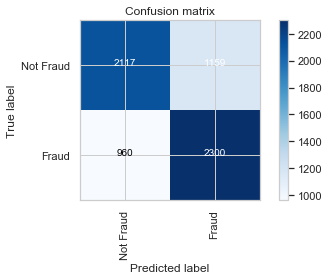

In [14]:
target_names = ['Not Fraud', 'Fraud']
cnf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')

#### Save best model 

In [15]:
import pickle

lookup ={
    1 : 'Fraud', 0:'Not Fraud'
}

pickle.dump(best_dt_classifier, open('../saved_models/dtc_model.pkl','wb'))
model = pickle.load(open('../saved_models/dtc_model.pkl','rb'))

#test the model 
pred = model.predict([X_test[0]])
lookup[pred[0]]

'Fraud'

#### Code Reference

- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://medium.com/@haydar_ai/learning-data-science-day-22-cross-validation-and-parameter-tuning-b14bcbc6b012
-  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html